In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import zipfile

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/My Drive/ML Project'

/content/drive/My Drive/ML Project


In [ ]:
tf.__version__

'2.7.0'

In [ ]:
pwd

'/content/drive/MyDrive/ML Project'

Sentiment Analysis using Pre-trained GloVe + LSTM

Downloading Pre-trained Glove Embeddings 

In [6]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

--2021-12-06 09:58:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-06 09:58:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-06 09:58:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [7]:
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [8]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
review_df = pd.read_csv("review_polarity.csv")

In [10]:
review_la = pd.read_csv("review_polarity_la.csv")

In [13]:
review_df.columns, review_la.columns

(Index(['Unnamed: 0', 'listing_id', 'id', 'date', 'reviewer_id',
        'reviewer_name', 'comments', 'language', 'polarity'],
       dtype='object'),
 Index(['Unnamed: 0', 'listing_id', 'id', 'date', 'reviewer_id',
        'reviewer_name', 'comments', 'language', 'polarity'],
       dtype='object'))

In [14]:
merged_reviews = review_df[["comments", "polarity"]].append(review_la[["comments", "polarity"]], ignore_index = True)

In [15]:
merged_reviews

,comments,polarity
0,Notre séjour de trois nuits. . Nous avons appr...,NaN
1,Great experience.,NaN
2,I've stayed with my friend at the Midtown Cast...,0.9248
3,"We've been staying here for about 9 nights, en...",0.9229
4,We had a wonderful stay at Jennifer's charming...,0.9464
...,...,...
1944667,I’ve been all over the U.S and this is the bes...,0.8975
1944668,"Genial! Casa nueva muy prolija, Alex un genio!",NaN
1944669,My stay here was very nice. All new appliances...,0.9509
1944670,"Great place, clean and cozy",0.7783


In [39]:
def convertScores(val):
    if val <= 0:
        return 0
    if val > 0:
        return 1

In [ ]:
review_df["Sentiment"] = review_df["polarity"].apply(convertScores)

In [ ]:
review_df["Sentiment"].value_counts()

In [40]:
merged_reviews["Sentiment"] = merged_reviews["polarity"].apply(convertScores)

In [41]:
merged_reviews["Sentiment"].value_counts()

1.0    1661622
0.0     123168
Name: Sentiment, dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def preProcess(text):
  tokens = re.sub("[^a-zA-Z]"," ", text).lower().split() 
  processed_text = [word.lower() for word in tokens if word.lower() not in stopwords.words('english')]
  lemmatize_text = [WordNetLemmatizer().lemmatize(word) for word in processed_text if not re.search('\d', word)]
  return " ".join(lemmatize_text)
    

In [ ]:
from tqdm import tqdm

In [ ]:
tqdm.pandas()
review_df['comments'] = review_df['comments'].progress_apply(preProcess)

100%|██████████| 755572/755572 [1:20:07<00:00, 157.15it/s]


In [ ]:
review_df.to_csv("tokenized_reviews.csv")

In [ ]:
review_df.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,Sentiment
2,2,2595,19760,2009-12-10,38960,Anita,stayed friend midtown castle six day lovely pl...,en,0.9248,1
3,3,2595,34320,2010-04-09,71130,Kai-Uwe,staying night enjoying center city never sleep...,en,0.9229,1
4,4,2595,46312,2010-05-25,117113,Alicia,wonderful stay jennifer charming apartment org...,en,0.9464,1
5,5,2595,1238204,2012-05-07,1783688,Sergey,hi everyone would say greatest compliment jenn...,en,0.9869,1
6,6,2595,1293632,2012-05-17,1870771,Loïc,jennifer friendly helpful place exactly advert...,en,0.9668,1


In [ ]:
X = review_df['comments']
y = review_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

Logistic Regression

In [ ]:
model = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                  ('tfidf', TfidfTransformer()),
                  ('model',LogisticRegression()),
                  ])
model.fit(X_train, y_train)
ytest = np.array(y_test)
pred_y = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
acc = accuracy_score(pred_y, y_test)
print('accuracy %s' % acc)
print(classification_report(ytest, pred_y))

accuracy 0.9563178914002296
              precision    recall  f1-score   support

          -1       0.70      0.37      0.49      2416
           0       0.83      0.64      0.72     24925
           1       0.97      0.99      0.98    274888

    accuracy                           0.96    302229
   macro avg       0.83      0.67      0.73    302229
weighted avg       0.95      0.96      0.95    302229



Linear SVC

In [ ]:
model_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    ('svm',LinearSVC()),
                    ])
model_svm.fit(X_train, y_train)
ytest = np.array(y_test)
pred_y = model_svm.predict(X_test)
acc = accuracy_score(y_predict, y_test)
print('accuracy %s' % acc)
print(classification_report(ytest, pred_y))

accuracy 0.9556826115296679
              precision    recall  f1-score   support

          -1       0.69      0.38      0.49      2416
           0       0.79      0.67      0.73     24925
           1       0.97      0.99      0.98    274888

    accuracy                           0.96    302229
   macro avg       0.82      0.68      0.73    302229
weighted avg       0.95      0.96      0.95    302229



Adaboost

In [ ]:
model_ab = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('ada', AdaBoostClassifier()),
                    ])
model_ab.fit(X_train, y_train)
ytest = np.array(y_test)
pred_y = model_ab.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print('accuracy %s' % acc)
print(classification_report(ytest, pred_y))

accuracy 0.9355290193859623
              precision    recall  f1-score   support

          -1       0.53      0.29      0.38      2416
           0       0.71      0.46      0.56     24925
           1       0.95      0.98      0.97    274888

    accuracy                           0.94    302229
   macro avg       0.73      0.58      0.63    302229
weighted avg       0.93      0.94      0.93    302229



In [ ]:
review_df["Sentiment"].isna().sum(), review_df["comments"].isna().sum()

(0, 0)

In [ ]:
review_df.dropna(subset = ["Sentiment", "comments"], inplace = True)

In [42]:
merged_reviews.dropna(subset = ["Sentiment", "comments"], inplace = True)

In [43]:
merged_reviews["Sentiment"].isna().sum(), merged_reviews["comments"].isna().sum()

(0, 0)

In [44]:
X = merged_reviews['comments']
y = merged_reviews['Sentiment']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state = 42)

In [45]:
len(X_train_sentences), len(X_test_sentences), len(y_train), len(y_test)

(535437, 1249353, 535437, 1249353)

In [ ]:
X = review_df['comments']
y = review_df['Sentiment']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

In [ ]:
len(X_train_sentences), len(X_test_sentences), len(y_train), len(y_test)

(453343, 302229, 453343, 302229)

In [ ]:
# import gensim
# model1 = gensim.models.Word2Vec(window=5, min_count=2, workers=8)
# model1.build_vocab(review_df['comments'])

In [47]:
tokenize = Tokenizer(num_words = 5000, oov_token="<OOV>")
tokenize.fit_on_texts(X_train_sentences)

In [48]:
word_index = tokenize.word_index

In [49]:
len(word_index)

98748

In [51]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)
X_train_pad = pad_sequences(X_train,maxlen=100, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test,maxlen=100, padding='post', truncating='post')

In [52]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [53]:
embedding_layer = Embedding(num_words,
                            100,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [54]:
%load_ext tensorboard

In [55]:
import datetime
log_dir=r"\Tensorboard_ex\logs_1\fit\"" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(16, return_sequences=True)), 
    Bidirectional(LSTM(16)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9321400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 32)          14976     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 198       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 9,342,853
Trainable params: 21,453
Non-t

In [ ]:
history = model.fit(X_train_pad, y_train,
                    batch_size=100,
                    epochs=2,
                    validation_data=(X_test_pad, y_test),
                    verbose=1, 
                    callbacks=[tensorboard_callback])

Epoch 1/2
4534/4534 [==============================] - 820s 179ms/step - loss: 0.0831 - accuracy: 0.9455 - val_loss: -0.1699 - val_accuracy: 0.9524
Epoch 2/2
4534/4534 [==============================] - 837s 185ms/step - loss: -0.5102 - accuracy: 0.9477 - val_loss: -1.3144 - val_accuracy: 0.9353


In [ ]:
loss, accuracy = model.evaluate(X_test_pad,y_test, callbacks=[tensorboard_callback])
print('Test accuracy :', accuracy)

9445/9445 [==============================] - 245s 26ms/step - loss: -1.3143 - accuracy: 0.9353
Test accuracy : 0.9352841973304749


In [ ]:
model1 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(16, return_sequences=True)), 
    Bidirectional(LSTM(16)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9321400   
                                                                 
 bidirectional_14 (Bidirecti  (None, 100, 32)          14976     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 6)                 198       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 9,342,853
Trainable params: 21,453
Non-t

In [ ]:
history = model1.fit(X_train_pad, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_data=(X_test_pad, y_test),
                    verbose=1, 
                    callbacks=[tensorboard_callback])

Epoch 1/5
7084/7084 [==============================] - 1059s 149ms/step - loss: 0.0475 - accuracy: 0.9848 - val_loss: 0.0391 - val_accuracy: 0.9855
Epoch 2/5
7084/7084 [==============================] - 1046s 148ms/step - loss: 0.0363 - accuracy: 0.9869 - val_loss: 0.0349 - val_accuracy: 0.9873
Epoch 3/5
7084/7084 [==============================] - 1064s 150ms/step - loss: 0.0329 - accuracy: 0.9879 - val_loss: 0.0325 - val_accuracy: 0.9880
Epoch 4/5
7084/7084 [==============================] - 1016s 143ms/step - loss: 0.0304 - accuracy: 0.9886 - val_loss: 0.0313 - val_accuracy: 0.9885
Epoch 5/5
7084/7084 [==============================] - 1050s 148ms/step - loss: 0.0283 - accuracy: 0.9894 - val_loss: 0.0305 - val_accuracy: 0.9887


In [ ]:
model1.save("sentiment_analysis_model2.h5")

In [ ]:
model.save("sentiment_model.h5")

In [ ]:
model.save("sentiment_analysis_model1.h5")

In [56]:
model2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(16, return_sequences=True)), 
    Bidirectional(LSTM(16)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9874900   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 32)          14976     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 9,896,353
Trainable params: 21,453
Non-tra

In [57]:
history = model2.fit(X_train_pad, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_data=(X_test_pad, y_test),
                    verbose=1, 
                    callbacks=[tensorboard_callback])

Epoch 1/5
8367/8367 [==============================] - 1401s 167ms/step - loss: 0.0955 - accuracy: 0.9641 - val_loss: 0.0808 - val_accuracy: 0.9685
Epoch 2/5
8367/8367 [==============================] - 1350s 161ms/step - loss: 0.0738 - accuracy: 0.9718 - val_loss: 0.0749 - val_accuracy: 0.9705
Epoch 3/5
8367/8367 [==============================] - 1342s 160ms/step - loss: 0.0664 - accuracy: 0.9747 - val_loss: 0.0660 - val_accuracy: 0.9748
Epoch 4/5
8367/8367 [==============================] - 1387s 166ms/step - loss: 0.0612 - accuracy: 0.9767 - val_loss: 0.0618 - val_accuracy: 0.9768
Epoch 5/5
8367/8367 [==============================] - 1390s 166ms/step - loss: 0.0576 - accuracy: 0.9782 - val_loss: 0.0589 - val_accuracy: 0.9778


In [58]:
loss, accuracy = model2.evaluate(X_test_pad,y_test, callbacks=[tensorboard_callback])
print('Test accuracy :', accuracy)

39043/39043 [==============================] - 804s 21ms/step - loss: 0.0589 - accuracy: 0.9778
Test accuracy : 0.9778261184692383


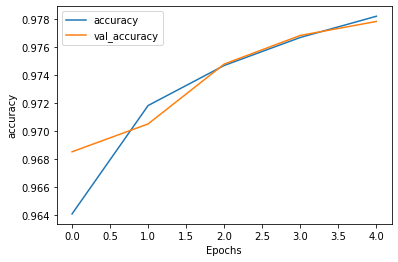

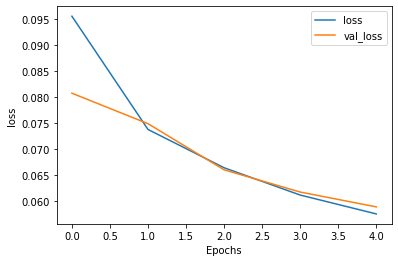

In [59]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [60]:
model2.save("sentiment_analysis_model3.h5")

In [ ]:
%tensorboard --logdir="\Tensorboard_ex\logs_1\fit"

In [ ]:
log_dir

'\\Tensorboard_ex\\logs_1\\fit\\"20211205-092019'

In [ ]:
pwd

'/content/drive/My Drive/ML Project'

In [ ]:
cd ..

/content/drive/My Drive


In [ ]:
#%tensorboard —-logdir=logs
%tensorboard --logdir="ML Project/logs" --port=8008